In [602]:
import pandas as pd
import seaborn as sns
import numpy as np

In [603]:
# Load links data
links_df = pd.read_csv('./data/links.csv')

# Load movies data
movies_df = pd.read_csv('./data/movies.csv')

# Load ratings data
ratings_df = pd.read_csv('./data/ratings.csv')

### Get important Movies genres

In [604]:
movies_df.genres = movies_df.genres.str.split('|')
movies_df

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]"
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]"
9739,193585,Flint (2017),[Drama]
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]"


In [605]:
genre_count = movies_df['genres'].explode().value_counts().reset_index()
genre_count.columns = ['genre', 'count']
genre_count = genre_count[genre_count["count"] > movies_df.size/25]
selected_genres = genre_count['genre'].tolist()
selected_genres

['Drama', 'Comedy', 'Thriller', 'Action', 'Romance', 'Adventure', 'Crime']

### Calculate users average rating for selected genres

In [606]:
users = pd.DataFrame(ratings_df['userId'].unique(), columns=['userId'])
ratings = pd.merge(movies_df, ratings_df, on='movieId')
for genre in selected_genres:
    genre_ratings = ratings[ratings['genres'].apply(lambda x: genre in x)]
    users[f"{genre}"] = users.apply(lambda x: genre_ratings[genre_ratings['userId'] == x['userId']]['rating'].mean(), axis=1)
users

,userId,Drama,Comedy,Thriller,Action,Romance,Adventure,Crime
0,1,4.529412,4.277108,4.145455,4.322222,4.307692,4.388235,4.355556
1,2,3.882353,4.000000,3.700000,3.954545,4.500000,4.166667,3.800000
2,3,0.750000,1.000000,4.142857,3.571429,0.500000,2.727273,0.500000
3,4,3.483333,3.509615,3.552632,3.320000,3.379310,3.655172,3.814815
4,5,3.800000,3.466667,3.555556,3.111111,3.090909,3.250000,3.833333
...,...,...,...,...,...,...,...,...
605,606,3.787966,3.565321,3.525126,3.178808,3.740845,3.503401,3.654135
606,607,4.012195,3.327273,4.114754,3.722222,3.517241,3.466667,3.814815
607,608,3.437500,2.736620,3.536680,3.330325,2.886792,3.220994,3.613014
608,609,3.368421,3.285714,3.285714,3.090909,3.200000,3.200000,3.500000


<Axes: >

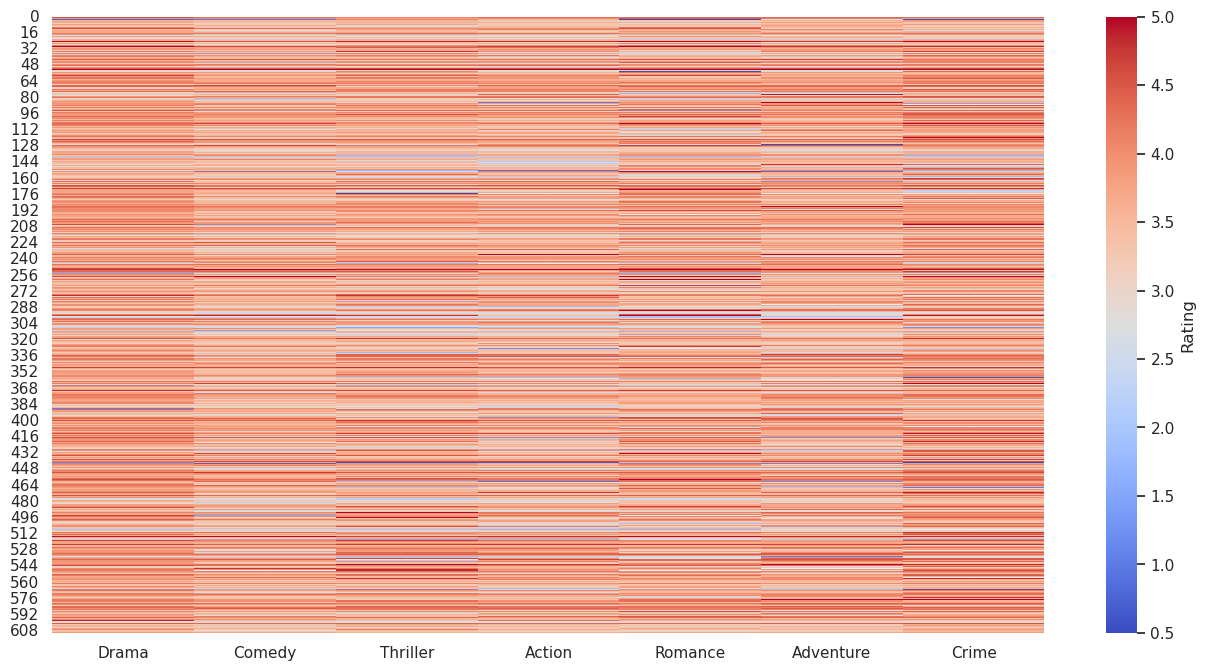

In [607]:
sns.set_theme(rc={'figure.figsize':(16,8)})
sns.heatmap(users.drop(["userId"], axis=1), cmap='coolwarm', cbar_kws={'label': 'Rating'})

### Cluster users with respect to average rating for selected genres

In [608]:
from sklearn.cluster import KMeans

In [609]:
users = users.fillna(4)

In [610]:
def getKMeansError(data, k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data.drop(["userId"], axis=1))
    return kmeans.inertia_

In [611]:
def plotError(data, start = 10, max_k=10, step = 1):
    errors = []
    for k in range(start, max_k, step):
        errors.append(getKMeansError(data, k))
    xticks = np.arange(start, max_k, step)
    errors_df = pd.DataFrame(np.array([errors, xticks]).T, columns=["errors", "xticks"])
    errors_df.plot(title="KMeans error", x="xticks", y="errors")

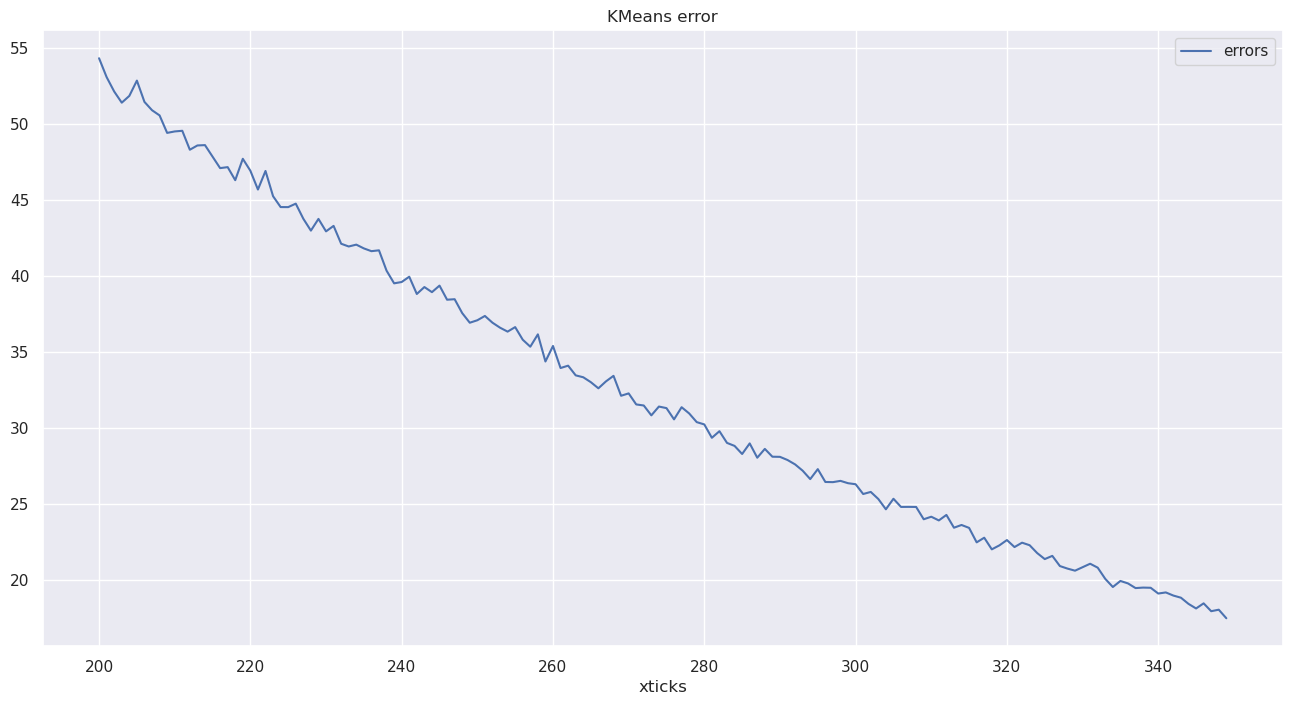

In [612]:
plotError(users, start = 200, max_k = 350, step = 1)

In [613]:
kmeans = KMeans(n_clusters=50)
usersCluster =  kmeans.fit(users.drop(["userId"], axis=1))
users['cluster'] = usersCluster.labels_
users

,userId,Drama,Comedy,Thriller,Action,Romance,Adventure,Crime,cluster
0,1,4.529412,4.277108,4.145455,4.322222,4.307692,4.388235,4.355556,7
1,2,3.882353,4.000000,3.700000,3.954545,4.500000,4.166667,3.800000,34
2,3,0.750000,1.000000,4.142857,3.571429,0.500000,2.727273,0.500000,19
3,4,3.483333,3.509615,3.552632,3.320000,3.379310,3.655172,3.814815,1
4,5,3.800000,3.466667,3.555556,3.111111,3.090909,3.250000,3.833333,1
...,...,...,...,...,...,...,...,...,...
605,606,3.787966,3.565321,3.525126,3.178808,3.740845,3.503401,3.654135,21
606,607,4.012195,3.327273,4.114754,3.722222,3.517241,3.466667,3.814815,22
607,608,3.437500,2.736620,3.536680,3.330325,2.886792,3.220994,3.613014,25
608,609,3.368421,3.285714,3.285714,3.090909,3.200000,3.200000,3.500000,42
